<a href="https://colab.research.google.com/github/a-mazzetto/potential-flow-pinns/blob/main/cylinder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Potential Flow past a Cylinder with Physics-Informed Neural Networks

## Table of contents

- [Introduction](#intro)
- [Problem Setting and Analytical Solution](#problem)
- [Physics-Informed Neural Network Solution](#pinns)
- [Experiments](#experiments)
- [Results](#results)
- [Conclusions](#conclusions)
- [References](#references)

<a name="intro"></a>
## Introduction

Physics-informed neural networks that solve Navier-Stokes equations are usually benchmarked against numerical solutions, given that in (almost) all applications the analytical solution is not available. There is a class of problems, however, that have numerical solutions [[1](#Ref1)] and could be used as a reference for deep learning solvers. Examples are the incompressible Couette, Poiseuille, Hagen-Poiseuille flows and the two-dimensional inviscid incompressible flow past a cylinder or a parametric Joukovskii aerofoil. In this post we base our analysis on the incompressible inviscid flow past a circular cylinder, and we will:
- Introduce the problem setting, analytical solution and physics-informed neural network problem setup
- Create and train a multi-layer perceptron with partial differential equations loss, impermeability loss and free stream loss

This code was run on Google Colab with an A100 GPU for the deep learning model training and inference. In the following cells please find some initial imports and a code cell useful in Google Colab to mount a Google Drive folder.

In [ ]:
from abc import ABC, abstractmethod
from typing import Union
import numpy as np
from numpy.typing import NDArray
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

root = "/content/drive/My Drive/cylinder/"

Mounted at /content/drive


In [ ]:
def complex_to_array(ll: np.typing.ArrayLike):
  return np.vstack((ll.real, ll.imag)).T

<a name="problem"></a>
## Problem Setting and Analytical Solution

We shall consider the inviscid (fluid viscosity $\nu=0$) incompressible (fluid density $\rho$ is constant) flow past a circular cylinder in the two-dimensional space, which obey the special case of Navier-Stokes equations known as Euler equations <a name="euler_equations"></a>:

$$u \frac{\partial u}{\partial x} + v \frac{\partial u}{\partial y} + \frac{1}{\rho} \frac{\partial p}{\partial x} = 0$$

$$u \frac{\partial v}{\partial x} + v \frac{\partial v}{\partial y} + \frac{1}{\rho} \frac{\partial p}{\partial y} = 0$$

$$\frac{\partial u}{\partial x} + \frac{\partial v}{\partial y} = 0$$

For simplicity and without loss of generality we will set $\rho=1$. Let us set the cylinder radius $a=1$ and angle of attack $\alpha$. The complex conjuugate of the velocity has an analytical expressione as follows [[1](#Ref1)]:

$$\bar{V}(z) = V_\infty \left( e^{-i \alpha} - \frac{a^2}{z^2 e^{-i \alpha}}\right)$$

where $z = x + i y$ is a complex representation of the two-dimensional space and $V_\infty$ is the far-field velocity. Using Bernoulli equation we can obtain the pressure field:

$$p = \rho \frac{v_\infty^2 - |V|^2}{2} + p_\infty$$

with $p_\infty$ the far-field pressure.

We define ageneral setting for solving two-dimensionalinviscid ncompressible flows of this sort, that are also called potential flows, and we define class for getting the boundary, filtering for the outer points and calculating the analytical velocity and pressure.

In [ ]:
class PotentialFlowShape(ABC):

  @abstractmethod
  def get_boundary(self, thetas: Union[float, NDArray[np.float64]], **kwargs):
    raise NotImplementedError()

  @abstractmethod
  def filter_outer(self, z: NDArray, **kwargs):
    raise NotImplementedError()

  @abstractmethod
  def velocity_field(self, z: NDArray, **kwargs):
    raise NotImplementedError()

  @abstractmethod
  def pressure_field(self, v: NDArray, **kwargs):
    raise NotImplementedError()


For a cylinder section, in particular, we define the boundary as the circumference. We also calculate the normal to the boundary, that we will se it is useful to define the impermeability condition. Velocity and pressure are defined as explained before.

In [ ]:
class Cylinder(PotentialFlowShape):

    def __init__(
            self,
            radius: float=1.0,
            v_inf: float=1.0,
            p_inf: float=1.0,
            rho: float=1.0,
            alpha: float=0.0,
            ):
        self.radius = radius
        self.v_inf = v_inf
        self.p_inf = p_inf
        self.rho = rho
        self.alpha = alpha

    def get_boundary(self, thetas: Union[float, NDArray[np.float64]]):
      """Sample from circle: vector and normal"""
      vector = self.radius * np.cos(thetas) + 1j * self.radius * np.sin(thetas)
      return vector, vector / np.absolute(vector)

    def filter_outer(self, z, strict: bool=False):
      bouter = np.absolute(z) > self.radius if strict else np.absolute(z) >= self.radius
      return bouter

    def velocity_field(self, z):
      """Cylinder velocity field"""
      rot = np.exp(-1j * self.alpha)
      v_vec_cc = self.v_inf * (rot - 1 / rot * self.radius**2 / z**2) # Complex conjugate of velocity
      v_vec = np.conjugate(v_vec_cc)
      return v_vec

    def pressure_field(self, v):
      """Pressure scalar field"""
      v_mod = np.absolute(v)
      return self.rho * (self.v_inf**2 - v_mod**2) / 2 + self.p_inf


Now we define tho helper functions to plot the flow in a grid and to inspect the boundary.

In [ ]:
def original_mesh_data(shape: PotentialFlowShape, bound: float, npoints: int):
  grid = np.linspace(-bound, bound, npoints)
  mesh = np.meshgrid(grid, grid)
  x_mesh = mesh[0].flatten()
  y_mesh = mesh[1].flatten()
  z_mesh = x_mesh + 1j * y_mesh
  b_mesh_outer = shape.filter_outer(z_mesh)
  z_mesh = z_mesh[b_mesh_outer]

  v_mesh = shape.velocity_field(z_mesh)
  p_mesh = shape.pressure_field(v_mesh)

  v_mesh_mod = np.absolute(v_mesh)
  v_mesh_angle = np.angle(v_mesh, deg=True)

  return z_mesh, v_mesh, p_mesh

def original_boundary_data(shape: PotentialFlowShape, npoints: int):
  theta_boundary = np.linspace(0, 2 * np.pi, npoints)
  z_boundary, n_boundary = shape.get_boundary(theta_boundary)
  v_boundary = shape.velocity_field(z_boundary)
  p_boundary = shape.pressure_field(v_boundary)

  return z_boundary, n_boundary, v_boundary, p_boundary

It is time to visualize the flow after initializing a cylinder with angle of attack 20 degrees.

In [ ]:
cylinder = Cylinder(alpha=20.0 * np.pi / 180.0)

z_mesh, v_mesh, p_mesh = original_mesh_data(cylinder, 2, 50)
z_boundary, n_boundary, v_boundary, p_boundary = original_boundary_data(cylinder, 40)

Let us start by visualizing the boundary and its normals, then the $v_x$ and $v_y$ velocity components, and finally the velocity field.

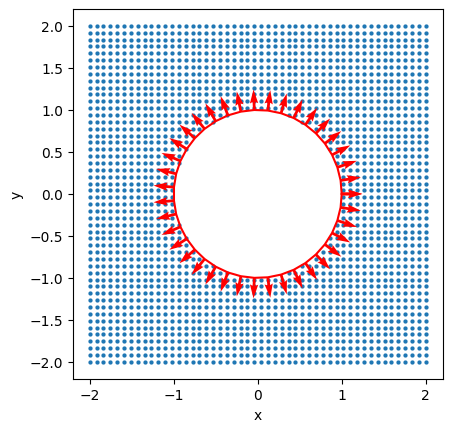

In [ ]:
plt.scatter(z_mesh.real, z_mesh.imag, marker=".", linewidths=0.05)
plt.plot(z_boundary.real, z_boundary.imag, color="red")
plt.quiver(z_boundary.real, z_boundary.imag, n_boundary.real, n_boundary.imag, color="red")
plt.xlabel("x")
plt.ylabel("y")
plt.gca().set_aspect(1)

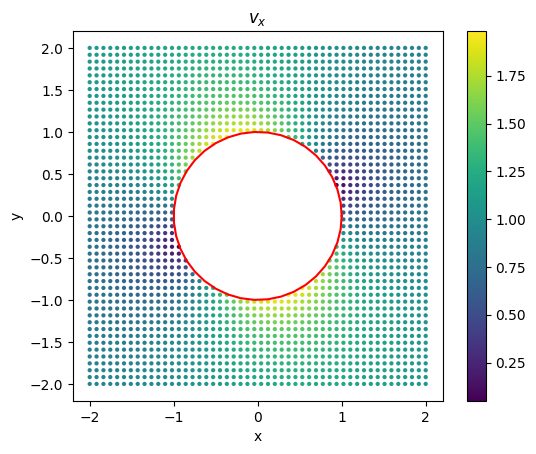

In [ ]:
v_mesh_mod = np.absolute(v_mesh)

plt.plot(z_boundary.real, z_boundary.imag, color="red")
plt.scatter(z_mesh.real, z_mesh.imag, c=v_mesh_mod, marker=".", linewidths=0.05)
plt.colorbar()
plt.title("$v_x$")
plt.xlabel("x")
plt.ylabel("y")
plt.gca().set_aspect(1)

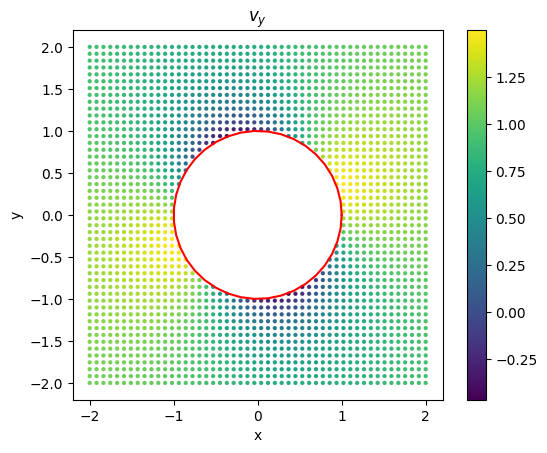

In [ ]:
plt.plot(z_boundary.real, z_boundary.imag, color="red")
plt.scatter(z_mesh.real, z_mesh.imag, c=p_mesh, marker=".", linewidths=0.05)
plt.colorbar()
plt.title("$v_y$")
plt.xlabel("x")
plt.ylabel("y")
plt.gca().set_aspect(1)

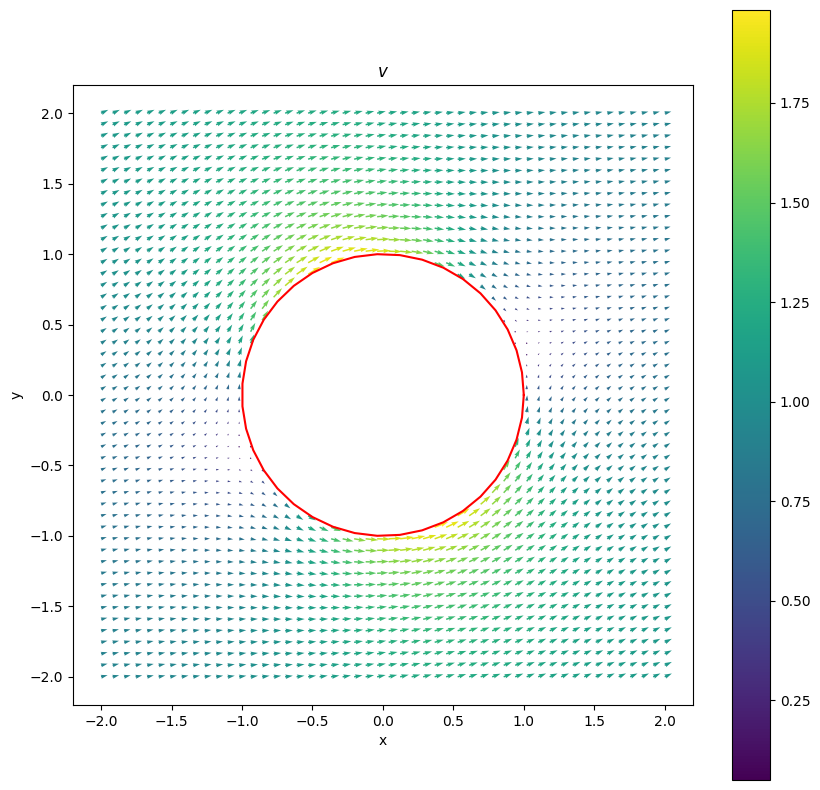

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(z_boundary.real, z_boundary.imag, color="red")
plt.quiver(z_mesh.real, z_mesh.imag, v_mesh.real, v_mesh.imag, v_mesh_mod)
plt.colorbar()
plt.title("$v$")
plt.xlabel("x")
plt.ylabel("y")
plt.gca().set_aspect(1)

We should note inp particular what happens at the boundary. For an inviscid flow we do ot define a sticky boundary, but an impermeable boundary instead: the velocity at the boundary must be tangent to the boundary itself. This is satisfied in the analytical solution as visualized below.

np.float64(-9.739653860802777e-18)

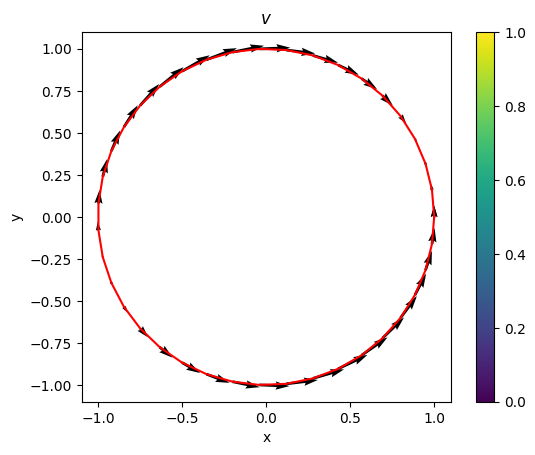

In [ ]:
plt.plot(z_boundary.real, z_boundary.imag, color="red")
plt.quiver(z_boundary.real, z_boundary.imag, v_boundary.real, v_boundary.imag)
plt.colorbar()
plt.title("$v$")
plt.xlabel("x")
plt.ylabel("y")
plt.gca().set_aspect(1)

# Track mean dot product
np.mean(np.sum(complex_to_array(n_boundary) * complex_to_array(v_boundary), axis=1))

A final remark on the flow past a cylinder is the positioning of the stagnation points at -160° and 20°. We wish to verify the position of the stagnation points in the deep learning solution as well. The position will be found using `scipy`'s `fsolve`. As a double check we find numerically the stagnation points in the analytical solution, and we find their position as expected.

In [ ]:
from scipy.optimize import fsolve

def stagnation_point_search(shape: PotentialFlowShape):

  z_boundary, _, v_boundary, _ = original_boundary_data(shape, 50)

  first_argmin = np.argmin(np.absolute(v_boundary))
  first_theta_min = np.angle(z_boundary[first_argmin])

  second_argmin = np.argmin(np.absolute(np.delete(v_boundary, first_argmin)))
  second_theta_min = np.angle(z_boundary[second_argmin])

  def internal_fn(t):
    z, _ = shape.get_boundary(t)
    v_mod = np.absolute(shape.velocity_field(z))

    return v_mod

  first_stagnation = fsolve(internal_fn, first_theta_min)
  second_stagnation = fsolve(internal_fn, second_theta_min)
  return np.array((first_stagnation, second_stagnation))


In [ ]:
stagnation_point_search(cylinder) * 180/np.pi

array([[-160.],
       [  20.]])

<a name="pinns"></a>
## Physics-Informed Neural Network Solution

We wish to traing a neural network $(v_x, v_y, p) = u(x, y)$. Our choice for $u$ is a multi-layer perceptron with 2 inputs, 3 outputs and 8 hiddel layers of dimension 128. We create a helper function `get_mlp` to create a multi-layer perceptron with PyTorch. Given that to calculate the partial differential equations losses we need the derivatives of the outputs with respect to $x$ and $y$ we create a helper function `calculate_derivatives` to calculate such derivatives with automatic differentiation.

In [ ]:
from typing import Union, List
from itertools import chain
import torch
import torch.nn as nn

def get_mlp(
    dimensions: List[int],
    hidden_activations: nn.Module = nn.SiLU,
    output_activation: nn.Module = nn.Identity,
    dtype = torch.float64,
    ):
  """MultiLayerPerceptron"""
  n = len(dimensions)
  layers = [nn.Linear(dimensions[i], dimensions[i + 1], dtype=dtype) for i in range(n - 1)]
  activations = (n - 2) * [hidden_activations()] + [output_activation()]
  return nn.Sequential(*chain(*zip(layers, activations)))

def calculate_derivatives(model, x, second=False):
    """Note: the second order derivative fails if independent upon X. Try for example
    the second order derivative of nn.Linear"""

    x.requires_grad = True
    assert x.is_leaf

    y = model(x)

    dys = []
    ddys = []

    for _y in torch.split(y, 1, dim=1):
      dy = torch.autograd.grad(_y, x, torch.ones_like(_y), create_graph=True)[0]
      dy.retain_grad()
      dys.append(dy)
      if second:
        for _dy in torch.split(dy, 1, dim=1):
            ddy = torch.autograd.grad(_dy, x, torch.ones_like(_dy), retain_graph=True)[0]
            ddys.append(ddy)
    if second:
        return y, torch.cat(dys, dim=1), torch.cat(ddys, dim=1)
    return y, torch.cat(dys, dim=1)


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Inputs: (x, y)
# Outputs: (u, v, p)
mlp = get_mlp([2] + 8 * [128] + [3])
mlp.to(device)
mlp

Sequential(
  (0): Linear(in_features=2, out_features=128, bias=True)
  (1): SiLU()
  (2): Linear(in_features=128, out_features=128, bias=True)
  (3): SiLU()
  (4): Linear(in_features=128, out_features=128, bias=True)
  (5): SiLU()
  (6): Linear(in_features=128, out_features=128, bias=True)
  (7): SiLU()
  (8): Linear(in_features=128, out_features=128, bias=True)
  (9): SiLU()
  (10): Linear(in_features=128, out_features=128, bias=True)
  (11): SiLU()
  (12): Linear(in_features=128, out_features=128, bias=True)
  (13): SiLU()
  (14): Linear(in_features=128, out_features=128, bias=True)
  (15): SiLU()
  (16): Linear(in_features=128, out_features=3, bias=True)
  (17): Identity()
)

So far we created our model. Now we need to create the losses that will give awareness of the geometry and constraints of our problem. First of all we need to satisfy the [Euler Equations](#euler_equations). We create a `PDELoss` that incorporates such equations, and test it.

In [ ]:
class PDELoss(torch.nn.Module):
    """Problem Loss"""
    def __init__(self, rho=1.0):
        super().__init__()
        self.rho = rho

    def forward(self, y, dydx, w_c: torch.Tensor=None, w_mx: torch.Tensor=None, w_my: torch.Tensor=None, dtype: torch.TensorType=None):
        """y = (u, v, p, du/dx, du/dy, dv/dx, dv/dy, dp/dx, dp/dy)"""
        dtype = dtype if dtype is not None else torch.float64
        w_c = w_c if w_c is not None else torch.tensor(1.0, dtype=dtype)
        w_mx = w_mx if w_mx is not None else torch.tensor(1.0, dtype=dtype)
        w_my = w_my if w_my is not None else torch.tensor(1.0, dtype=dtype)

        u, v, p = torch.split(y, 1, dim=1)
        dudx, dudy, dvdx, dvdy, dpdx, dpdy = torch.split(dydx, 1, dim=1)

        pde_mx = u * dudx + v * dudy + dpdx / self.rho
        pde_my = u * dvdx + v * dvdy + dpdy / self.rho
        pde_c = dudx + dvdy

        return (
            torch.nn.functional.mse_loss(pde_mx, torch.zeros_like(w_mx * pde_mx)),
            torch.nn.functional.mse_loss(pde_my, torch.zeros_like(w_my * pde_my)),
            torch.nn.functional.mse_loss(pde_c, torch.zeros_like(w_c * pde_c)),
        )

pde_loss = PDELoss().to(device)

x_test = torch.tensor([[1.0, 0.0]], dtype=torch.float64).to(device)
pde_loss(*calculate_derivatives(mlp, x_test))

(tensor(9.7044e-11, device='cuda:0', dtype=torch.float64,
        grad_fn=<MseLossBackward0>),
 tensor(3.3782e-10, device='cuda:0', dtype=torch.float64,
        grad_fn=<MseLossBackward0>),
 tensor(3.4412e-09, device='cuda:0', dtype=torch.float64,
        grad_fn=<MseLossBackward0>))

Secondly, we need to constrain the model based on the geometry. The condition on the cylinder boundary is that the flow should not permeate: in other words, the velocity vector and normal to the boundary should be perpendicular. The `ImpermeabilityLoss` defined below is in fact a dot product whoich should be zero on the boundary.

In [ ]:
class ImpermeabilityLoss(torch.nn.Module):
    """Impermeability loss"""

    def forward(self, normals, outputs, w: torch.Tensor=None, dtype: torch.TensorType=None):
      dtype = dtype if dtype is not None else torch.float64

      w = w if w is not None else torch.tensor(1.0, dtype=dtype)

      x, y = torch.split(normals, 1, dim=1)
      u, v, p = torch.split(outputs, 1, dim=1)

      dot_product = w * (x * u + y * v)

      return torch.nn.functional.mse_loss(dot_product, torch.zeros_like(dot_product))

impermeability_loss = ImpermeabilityLoss().to(device)

test_tensor = torch.tensor([[1.0, 0.0]], dtype=torch.float64).to(device)
test_result = mlp(test_tensor)
impermeability_loss(test_tensor, test_result)

tensor(0.0002, device='cuda:0', dtype=torch.float64,
       grad_fn=<MseLossBackward0>)

So far we defined what is the condition for the flow at any point (Euler equations) and what is the condition on the boundary. To complete the description of our problem we need to define which is the velocity afar. This is called free stream condition, and the velocity in a region far prom the object is simply dictated.

In [ ]:
class FreeStreamLoss(torch.nn.Module):
    """Impermeability loss"""
    def __init__(self, v_inf, alpha, p_inf):
        super().__init__()
        self.vx_inf = torch.tensor(v_inf * np.cos(alpha))
        self.vy_inf = torch.tensor(v_inf * np.sin(alpha))
        self.p_inf = p_inf

    def forward(self, outputs):
        vx, vy, p = torch.split(outputs, 1, dim=1)
        return (
            torch.nn.functional.mse_loss(vx, self.vx_inf * torch.ones_like(vx)) +
            torch.nn.functional.mse_loss(vy, self.vy_inf * torch.ones_like(vy)),
            torch.nn.functional.mse_loss(p, self.p_inf * torch.ones_like(p))
        )

freestream_loss = FreeStreamLoss(v_inf=cylinder.v_inf, alpha=cylinder.alpha, p_inf=cylinder.p_inf).to(device)

test_tensor = torch.tensor([[1.0, 0.0]], dtype=torch.float64).to(device)
test_result = mlp(test_tensor)
freestream_loss(test_result)

(tensor(1.0205, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>),
 tensor(1.0579, device='cuda:0', dtype=torch.float64,
        grad_fn=<MseLossBackward0>))

For completeness, the potential flow under consideration also has a constraint called _Kutta condition_ that imposes no circulation of the flow at the trailing edge. Our problem is symmetric, and this condition is automatically satisfied. Hence, we do not need to impose the Kutta condition like we would need to do for other problems like the Joukovskii aerofoil.

After defining the loss functions we are left with an important task that is to generate the datapoints on which to calculate the various loss terms. We need to:
- Generate points afar from the object: we call that horizon
- Generate points on the object boundary
- Generate points in between
We now describe such functions.

We would like to point out two aspects here:
1. We wish to generate new data points at each training iteration, like if our dataset was virtually infinite
2. We generate the random data with Sobol sequences to cover the space more uniformly [[2](#sobol)] by default

The function `generate_boundary` samples points on the boundary and returns their coordinates as well as the cooresponding normal vectors.

The function `generate_exterior` samples randomly in a square and returns only the points outside the shape.

The function `generate_horizon` samples points on a circle.

Finally, the function `generate_data` generates the data for our probloem specifically, using the above functions. As we wish to test different horizons (i.e. different free stream conditions ad various distances from the shape), we define a maximum horizon to sample always the same points with `generate_exterior` and then restrich ourselves to the actual horizon in consideration.

In [ ]:
from scipy.stats import qmc

np.random.seed(0)

sobol_sampler_1d = qmc.Sobol(d=1, rng=np.random.default_rng(seed=0), bits=64)
sobol_sampler_2d = qmc.Sobol(d=2, rng=np.random.default_rng(seed=0), bits=64)

def generate_boundary(
    shape: PotentialFlowShape,
    n_boundary_samples: int=1000,
    use_sobol: bool=True,
    seed: int=0,
):
  if use_sobol:
    sampler = qmc.Sobol(d=1, rng=np.random.default_rng(seed=seed), bits=64)
    boundary_theta_sample = qmc.scale(
        sampler.random(n=n_boundary_samples), 0, 2 * np.pi).flatten()
  else:
    rng = np.random.default_rng(seed=seed)
    boundary_theta_sample = rng.uniform(0, 2 * np.pi, n_boundary_samples)
  boundary_points, boundary_normals = shape.get_boundary(boundary_theta_sample)
  boundary_points = complex_to_array(boundary_points)
  boundary_normals = complex_to_array(boundary_normals)
  return boundary_points, boundary_normals

def generate_exterior(
    shape: PotentialFlowShape,
    r_horizon: float=7,
    rho_exterior_samples: int=1000,
    use_sobol: bool=True,
    seed: int=0,
):
  n_exterior_samples = int(rho_exterior_samples * r_horizon**2)
  if use_sobol:
    sampler = qmc.Sobol(d=2, rng=np.random.default_rng(seed=seed), bits=64)
    exterior_sample = qmc.scale(sampler.random(n=n_exterior_samples), -r_horizon, r_horizon)
  else:
    rng = np.random.default_rng(seed=seed)
    exterior_sample = rng.uniform(-r_horizon, r_horizon, size=(n_exterior_samples, 2))
  exterior_sample_absolute = np.sqrt(np.sum(exterior_sample**2, axis=1))
  exterior_sample_complex = exterior_sample[:, 0] + 1j * exterior_sample[:, 1]
  valid_exterior_sample = cylinder.filter_outer(exterior_sample_complex) & (exterior_sample_absolute < r_horizon)
  exterior_points = exterior_sample[valid_exterior_sample]
  return exterior_points

def generate_horizon(
    shape: PotentialFlowShape,
    r_horizon: float=7,
    rho_horizon_samples: int=1000,
    use_sobol: bool=False,
    seed: int=0,
):
  n_horizon_samples = int(rho_horizon_samples * r_horizon / 2)
  if use_sobol:
    sampler = qmc.Sobol(d=1, rng=np.random.default_rng(seed=seed), bits=64)
    horizon_theta_sample = qmc.scale(sampler.random(n=n_horizon_samples), 0, 2 * np.pi).flatten()
  else:
    rng =np.random.default_rng(seed=seed)
    horizon_theta_sample = rng.uniform(0, 2 * np.pi, 1000)
  horizon_points = np.vstack(
      (r_horizon * np.cos(horizon_theta_sample),
       r_horizon * np.sin(horizon_theta_sample)
       )
      ).T
  return horizon_points

def generate_data(
    r_horizon: float=7,
    r_horizon_max: float=10,
    n_boundary_samples: int=1000,
    rho_exterior_samples: int=1000,
    rho_horizon_samples: int=1000,
    r_pde_downweight: float=3,
    use_sobol: bool=False,
    ):
  boundary_points, boundary_normals = generate_boundary(
      cylinder,
      n_boundary_samples=n_boundary_samples,
      use_sobol=use_sobol,
  )

  exterior_points = generate_exterior(
      cylinder,
      r_horizon=r_horizon_max,
      rho_exterior_samples=rho_exterior_samples,
      use_sobol=use_sobol,
  )
  exterior_points= exterior_points[
      np.sqrt(np.sum(exterior_points**2, axis=1)) < r_horizon
  ]

  horizon_points = generate_horizon(
      cylinder,
      r_horizon=r_horizon,
      rho_horizon_samples=rho_horizon_samples,
      use_sobol=use_sobol,
  )

  pde_points = np.concatenate((boundary_points, exterior_points, horizon_points))
  delta_points = r_horizon**2 / r_pde_downweight**2
  pde_weights = np.where(np.sqrt((pde_points**2).sum()) < r_pde_downweight, 1 - 1 / delta_points, 1 / delta_points)

  return pde_points, pde_weights, boundary_points, boundary_normals, horizon_points


We test our data generating function and plot the sample.

(8782, 2)


/tmp/ipython-input-1880834055.py:17: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sampler.random(n=n_boundary_samples), 0, 2 * np.pi).flatten()
/tmp/ipython-input-1880834055.py:36: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  exterior_sample = qmc.scale(sampler.random(n=n_exterior_samples), -r_horizon, r_horizon)
/tmp/ipython-input-1880834055.py:56: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  horizon_theta_sample = qmc.scale(sampler.random(n=n_horizon_samples), 0, 2 * np.pi).flatten()


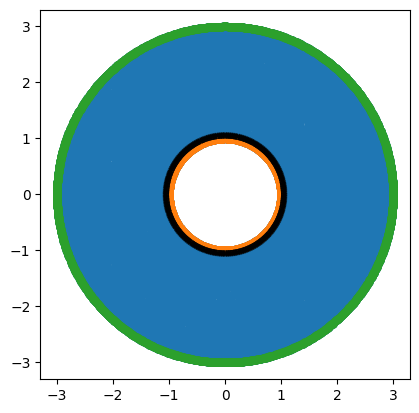

In [ ]:
pde_points, pde_weights, boundary_points, boundary_normals, horizon_points = generate_data(r_horizon=3, use_sobol=True)
print(pde_points.shape)

plt.scatter(pde_points[:, 0], pde_points[:, 1], linewidths=0.01)
plt.scatter(boundary_points[:, 0], boundary_points[:, 1], linewidths=0.01)
plt.quiver(boundary_points[:, 0], boundary_points[:, 1], boundary_normals[:, 0], boundary_normals[:, 1])
plt.scatter(horizon_points[:, 0], horizon_points[:, 1], linewidths=0.01)
plt.gca().set_aspect(1)

Physics-informed neural networks have multiple loss terms for differential equations and boundary conditions. Instead of defining the relative loss weights a priori, there are schemas whereby the loss term weights are updated iteratively. One of these is the SoftAdapt [[3](#softadapt)] loss weight update, implemented below. We wish to test it in our problem.

In [ ]:
class SoftAdaptLossAggregation(torch.nn.Module):

  def __init__(self):
    super().__init__()
    self.eps = 1e-5
    self.register_buffer("previous_losses", None, persistent=False)

  def forward(self, losses: torch.types.Tensor):
    if self.previous_losses is None:
      weights = torch.ones_like(losses) / torch.numel(losses)
    else:
      with torch.no_grad():
        p = losses / (self.previous_losses + self.eps)
        weights = torch.softmax(p - p.max(), dim=0)
    loss = torch.dot(losses, weights)
    self.previous_losses = losses
    return loss, losses, weights

Finally, we train our model with an Adam optimizer. The training loop is standard: training data is sampled at each iteration, the losses calculated and the model weights optimised and updated.

In [ ]:
optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-4)

# %% Training
def train_one_batch(model, r_horizon: float, loss_agg_fn = None):
    # Zero your gradients for every batch!

    # Make predictions for this batch
    pde_points, pde_weights, boundary_points, boundary_normals, horizon_points = generate_data(
        use_sobol=True,
        r_horizon=r_horizon,
    )
    pde_points = torch.tensor(pde_points, dtype=torch.float64).to(device)
    pde_weights = torch.tensor(pde_weights, dtype=torch.float64).to(device)
    boundary_points = torch.tensor(boundary_points, dtype=torch.float64).to(device)
    boundary_normals = torch.tensor(boundary_normals, dtype=torch.float64).to(device)
    horizon_points = torch.tensor(horizon_points, dtype=torch.float64).to(device)

    pde_pred = calculate_derivatives(model, pde_points)
    boundary_pred = model(boundary_points)
    horizon_pred = model(horizon_points)

    # Compute the loss and its gradients
    loss_mx, loss_my, loss_c = pde_loss(*pde_pred, w_c=pde_weights, w_mx=pde_weights, w_my=pde_weights)
    loss_imp = impermeability_loss(boundary_normals, boundary_pred)
    loss_free_v, loss_free_p = freestream_loss(horizon_pred)

    current_losses = torch.stack((loss_mx, loss_my, loss_c, loss_imp, loss_free_v, loss_free_p))
    if loss_agg_fn is not None:
      loss, _, current_loss_weights = loss_agg_fn(current_losses)
    else:
      current_loss_weights = torch.ones_like(current_losses)
      loss = torch.dot(current_loss_weights, current_losses)

    optimizer.zero_grad()

    loss.backward()

    # Adjust learning weights
    optimizer.step()

    # Print loss
    return (
        loss.detach().cpu().numpy(),
        current_losses.detach().cpu().numpy(),
        current_loss_weights.detach().cpu().numpy(),
        )

In [ ]:
train_one_batch(mlp, r_horizon=3, loss_agg_fn=SoftAdaptLossAggregation())

/tmp/ipython-input-1880834055.py:17: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sampler.random(n=n_boundary_samples), 0, 2 * np.pi).flatten()
/tmp/ipython-input-1880834055.py:36: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  exterior_sample = qmc.scale(sampler.random(n=n_exterior_samples), -r_horizon, r_horizon)
/tmp/ipython-input-1880834055.py:56: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  horizon_theta_sample = qmc.scale(sampler.random(n=n_horizon_samples), 0, 2 * np.pi).flatten()


(array(0.34644176),
 array([8.78828624e-11, 3.75401237e-10, 4.57108411e-09, 2.02480111e-04,
        1.02055361e+00, 1.05789445e+00]),
 array([0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
        0.16666667]))

Throughout training we wish to validate our model on the same grid of data. We create a helper function for model predictions and a helper function to calculate validation mean absolute errors.

In [ ]:
def predict(model: torch.nn.Module, z: np.typing.NDArray[np.complex64]):
  pred = model(
      torch.tensor(complex_to_array(z), dtype=torch.float64).to(device)
  )
  v = pred[:, 0].cpu().detach().numpy() + 1j * pred[:, 1].cpu().detach().numpy()
  p = pred[:, 2].cpu().detach().numpy()

  return v, p


In [ ]:
def validation_metrics(
    v_mesh: NDArray[np.complex64],
    v_mesh_pred: NDArray[np.complex64],
    p_mesh:NDArray[np.complex64],
    p_mesh_pred:NDArray[np.complex64],
    n_boundary: NDArray[np.complex64],
    v_boundary_pred: NDArray[np.complex64],
):
  vx_mae = np.abs(v_mesh.real - v_mesh_pred.real).mean()
  vy_mae = np.abs(v_mesh.imag - v_mesh_pred.imag).mean()
  p_mae = np.abs(p_mesh - p_mesh_pred).mean()
  impermeability_error = np.mean(
      np.sum(
          complex_to_array(n_boundary) * complex_to_array(v_boundary_pred),
          axis=1,
          )
      )

  return vx_mae, vy_mae, p_mae, impermeability_error

Below is the code to launch model training. Some parameters are configurable in this cell:

- `bsoftadaptloss`: whether to use the SoftAdapt loss weights
- `r_horizon`: horizon with respect to the characteristic length $1$. The theoretical horizon is $\infty$ but in practice we have to try finite horizons
- `budget`
- `validation_interval`: validation frequency

In [ ]:
import os
from copy import deepcopy
import tqdm as tqdm
from torch.utils.tensorboard import SummaryWriter

bsoftadaptloss = False
softadaptloss = SoftAdaptLossAggregation()
r_horizon = 5

name_id = "final_horizon_5_45kit"
log_dir = os.path.join("/content/", name_id)
writer = SummaryWriter(log_dir=log_dir)

budget = 45000
validation_interval = 1000
best_loss = 1e9

model_for_validation = deepcopy(mlp)

history = []
pbar = tqdm.tqdm(range(budget))
for epoch in pbar:
    _h = train_one_batch(mlp, r_horizon=r_horizon, loss_agg_fn=(softadaptloss if bsoftadaptloss else None))

    # print(_h[1], _h[2])

    writer.add_scalar("Loss/loss", _h[0], epoch)

    writer.add_scalar("Loss/pde_mx_loss", _h[1][0], epoch)
    writer.add_scalar("Loss/pde_my_loss", _h[1][1], epoch)
    writer.add_scalar("Loss/pde_c_loss", _h[1][2], epoch)
    writer.add_scalar("Loss/impermeability_loss", _h[1][3], epoch)
    writer.add_scalar("Loss/freeflow_v_loss", _h[1][4], epoch)
    writer.add_scalar("Loss/freeflow_p_loss", _h[1][5], epoch)

    writer.add_scalar("Loss/pde_mx_loss_w", _h[2][0], epoch)
    writer.add_scalar("Loss/pde_my_loss_w", _h[2][1], epoch)
    writer.add_scalar("Loss/pde_c_loss_w", _h[2][2], epoch)
    writer.add_scalar("Loss/impermeability_loss_w", _h[2][3], epoch)
    writer.add_scalar("Loss/freeflow_v_loss_w", _h[2][4], epoch)
    writer.add_scalar("Loss/freeflow_p_loss_w", _h[2][5], epoch)

    if _h[0] < best_loss:
      best_loss = _h[0]
      best_model_state_dict = deepcopy(mlp.state_dict())

    # Validation
    if epoch % validation_interval == 0:
      model_for_validation.load_state_dict(best_model_state_dict)

      _, v_mesh, p_mesh = original_mesh_data(cylinder, 2, 50)
      _, n_boundary, _, _ = original_boundary_data(cylinder, 40)

      v_mesh_pred, p_mesh_pred = predict(model_for_validation, z_mesh)
      v_boundary_pred, _ = predict(model_for_validation, z_boundary)

      vx_mae, vy_mae, p_mae, impermeability_error = validation_metrics(
          v_mesh,
          v_mesh_pred,
          p_mesh,
          p_mesh_pred,
          n_boundary,
          v_boundary_pred,
      )

      writer.add_scalar("Validation/vx_mae", vx_mae, epoch)
      writer.add_scalar("Validation/vy_mae", vy_mae, epoch)
      writer.add_scalar("Validation/p_mae", p_mae, epoch)
      writer.add_scalar("Validation/impermeability_error", impermeability_error, epoch)

      pbar.set_postfix({"vx_mae": vx_mae, "vy_mae": vy_mae, "p_mae": p_mae, "imp_error": impermeability_error})

    history.append(_h)

mlp.load_state_dict(best_model_state_dict)
torch.save(mlp, log_dir + "/best_model.pt")

  0%|          | 0/1 [00:00<?, ?it/s]/tmp/ipython-input-1880834055.py:17: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sampler.random(n=n_boundary_samples), 0, 2 * np.pi).flatten()
/tmp/ipython-input-1880834055.py:36: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  exterior_sample = qmc.scale(sampler.random(n=n_exterior_samples), -r_horizon, r_horizon)
/tmp/ipython-input-1880834055.py:56: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  horizon_theta_sample = qmc.scale(sampler.random(n=n_horizon_samples), 0, 2 * np.pi).flatten()
100%|██████████| 1/1 [00:00<00:00,  1.67it/s, vx_mae=0.951, vy_mae=0.371, p_mae=0.937, imp_error=-0.000264]


In [ ]:
import shutil

shutil.copytree(log_dir, root + name_id)

In [ ]:
# import os

# name_id = "final_horizon_5_45kit"

# log_dir = os.path.join("/content/drive/My Drive/cylinder/", name_id)

# model_path = log_dir + "/best_model.pt"
# model_path

# mlp = torch.load(model_path, weights_only=False) # map_location=torch.device('cpu')

# Diagnostics

Below are some functions to compare predictions and analytical solution. We wish to compare the velcoity fields, the pressure field, the impermeability condition and the stagnation points positioning.

In [ ]:
from matplotlib import colors

def plot_flow_field_comparison(
    z_boundary: NDArray[np.complex64],
    true_vectors: NDArray[np.complex64],
    predicted_vectors: NDArray[np.complex64]
    ):
  plt.ioff()

  true_absolute = np.absolute(v_mesh)
  predicted_absolute = np.absolute(predicted_vectors)

  fig, axs = plt.subplots(1, 3, figsize=(15, 11))

  norm = colors.Normalize(vmin=true_absolute.min(), vmax=true_absolute.max())

  axs[0].set_title("True Flow Field")
  axs[0].plot(z_boundary.real, z_boundary.imag, color="red")
  quiver_0 = axs[0].quiver(z_mesh.real, z_mesh.imag, v_mesh.real, v_mesh.imag, np.absolute(v_mesh), norm=norm)
  axs[0].set_aspect(1)

  axs[1].set_title("Predicted Flow Field")
  axs[1].plot(z_boundary.real, z_boundary.imag, color="red")
  quiver_1 = axs[1].quiver(z_mesh.real, z_mesh.imag, v_mesh_pred.real, v_mesh_pred.imag, np.absolute(v_mesh_pred), norm=norm)
  axs[1].set_aspect(1)

  axs[2].set_axis_off()
  fig.colorbar(quiver_0, ax=axs[2], orientation='vertical', fraction=1, shrink=0.5)

  return fig

def plot_mesh_comparison(
    z_boundary: NDArray[np.complex64],
    z_mesh: NDArray[np.complex64],
    true_quantity: NDArray[np.float64],
    predicted_quantity: NDArray[np.float64],
    quantity_name: str):
  plt.ioff()

  fig, axs = plt.subplots(2, 3, figsize=(15, 11))

  norm = colors.Normalize(vmin=true_quantity.min(), vmax=true_quantity.max())

  axs[0, 0].set_title(f"True {quantity_name}")
  axs[0, 0].plot(z_boundary.real, z_boundary.imag, color="red")
  scatter_0 = axs[0, 0].scatter(z_mesh.real, z_mesh.imag, c=true_quantity, marker=".", norm=norm)
  axs[0, 0].set_aspect(1)

  axs[0, 1].set_title(f"Predicted {quantity_name}")
  axs[0, 1].plot(z_boundary.real, z_boundary.imag, color="red")
  scatter_1 = axs[0, 1].scatter(z_mesh.real, z_mesh.imag, c=predicted_quantity, marker=".", norm=norm)
  axs[0, 1].set_aspect(1)

  axs[0, 2].set_title(f"Delta {quantity_name}")
  axs[0, 2].plot(z_boundary.real, z_boundary.imag, color="red")
  scatter_2 = axs[0, 2].scatter(z_mesh.real, z_mesh.imag, c=predicted_quantity - true_quantity, marker=".")
  axs[0, 2].set_aspect(1)

  axs[1, 0].set_axis_off()
  axs[1, 1].set_axis_off()
  axs[1, 2].set_axis_off()
  fig.colorbar(scatter_0, ax=axs[1, 0], orientation='horizontal', fraction=1, shrink=0.9)
  fig.colorbar(scatter_1, ax=axs[1, 1], orientation='horizontal', fraction=1, shrink=0.9)
  fig.colorbar(scatter_2, ax=axs[1, 2], orientation='horizontal', fraction=1, shrink=0.9)

  return fig

def plot_impermeability(
    z_boundary: NDArray[np.complex64],
    v_boundary_pred: NDArray[np.complex64]
    ):
  plt.ioff()
  fig, axs = plt.subplots(1)
  axs.plot(z_boundary.real, z_boundary.imag, color="red")
  quiver = axs.quiver(z_boundary.real, z_boundary.imag, v_boundary_pred.real, v_boundary_pred.imag)
  axs.set_aspect(1)
  plt.colorbar(quiver)

  return fig

In [ ]:
z_mesh, v_mesh, p_mesh = original_mesh_data(cylinder, 2, 50)
z_boundary, n_boundary, v_boundary, p_boundary = original_boundary_data(cylinder, 40)

v_mesh_pred, p_mesh_pred = predict(mlp, z_mesh)
v_boundary_pred, p_boundary_pred = predict(mlp, z_boundary)

validation_metrics(
    v_mesh,
    v_mesh_pred,
    p_mesh,
    p_mesh_pred,
    n_boundary,
    v_boundary_pred,
)

(np.float64(0.01632993264306764),
 np.float64(0.006623994069959964),
 np.float64(0.024883827623160392),
 np.float64(3.2748592244042076e-05))

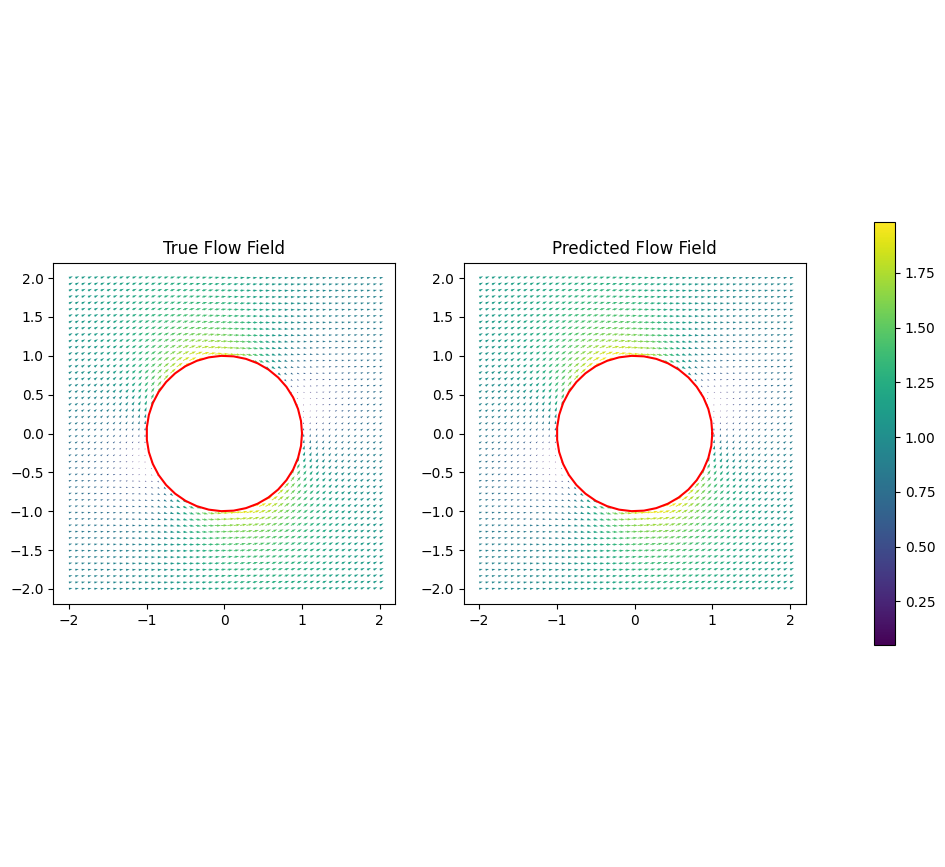

In [ ]:
plot_flow_field_comparison(z_boundary, v_mesh, v_mesh_pred)

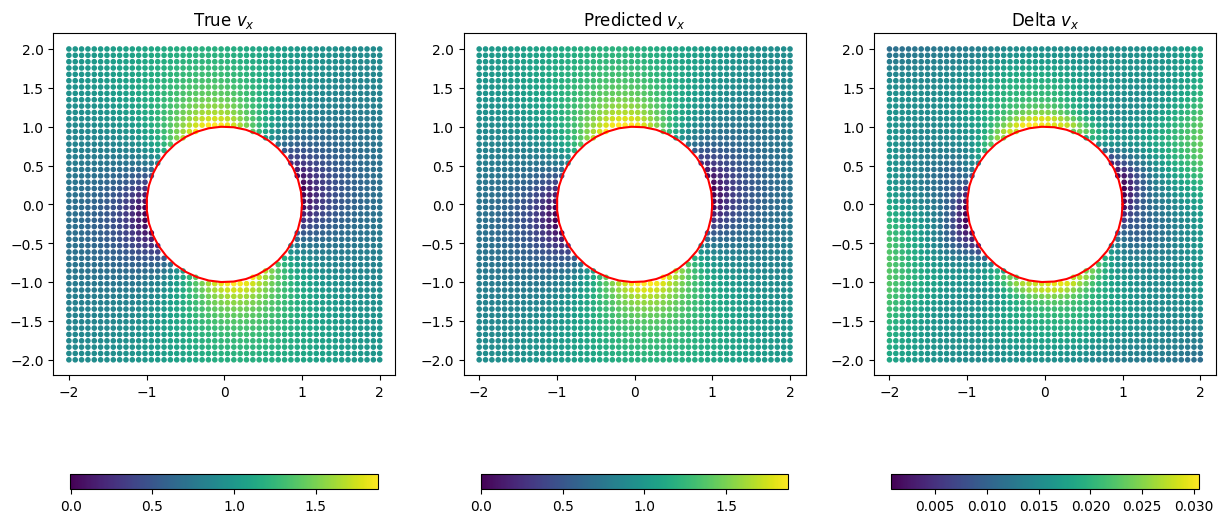

In [ ]:
plot_mesh_comparison(z_boundary, z_mesh, v_mesh.real, v_mesh_pred.real, "$v_x$")

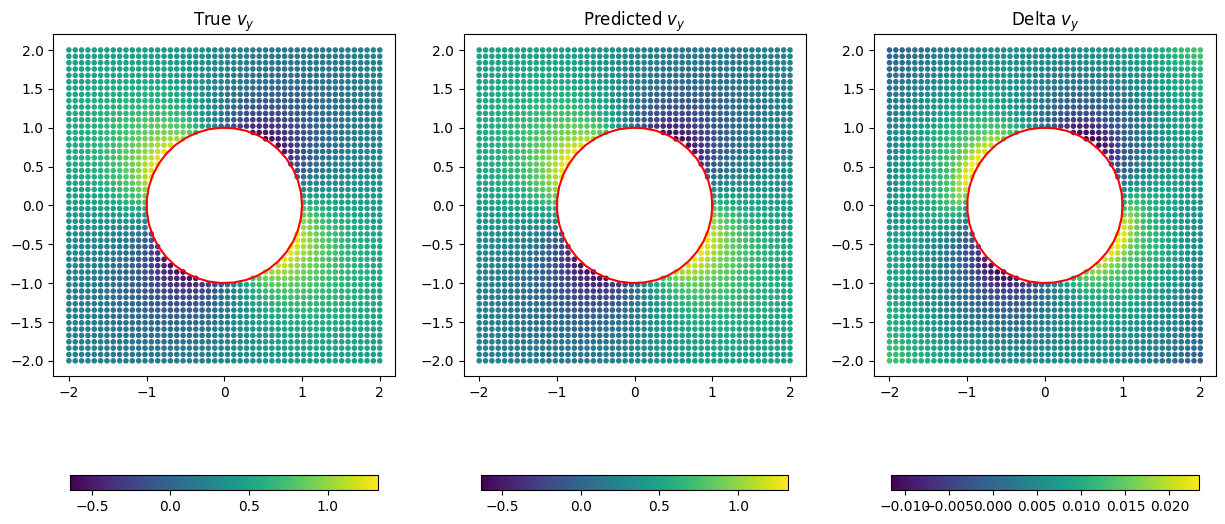

In [ ]:
plot_mesh_comparison(z_boundary, z_mesh, v_mesh.imag, v_mesh_pred.imag, "$v_y$")

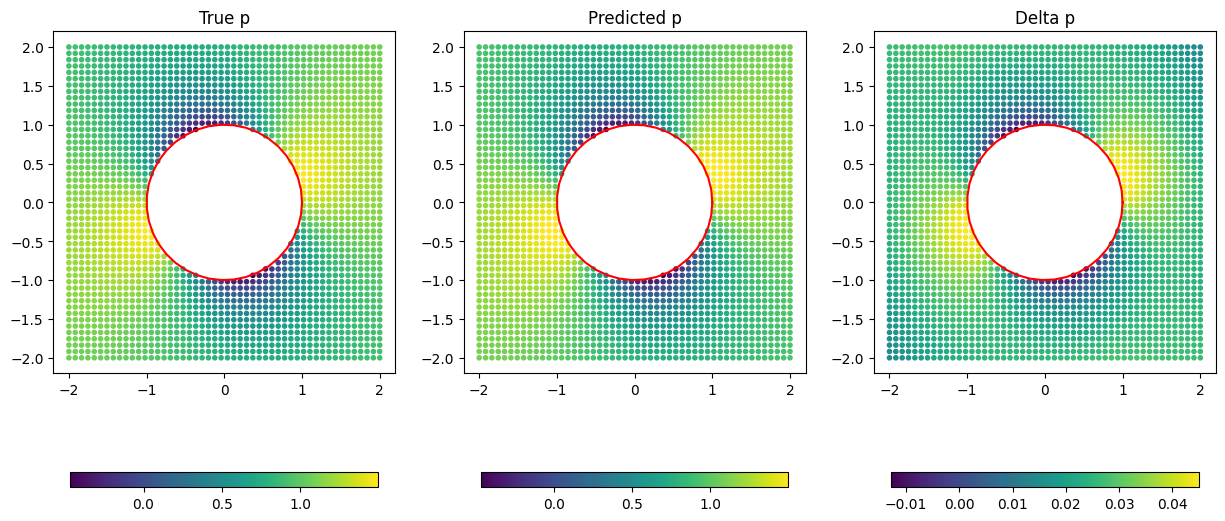

In [ ]:
plot_mesh_comparison(z_boundary, z_mesh, p_mesh, p_mesh_pred, "p")

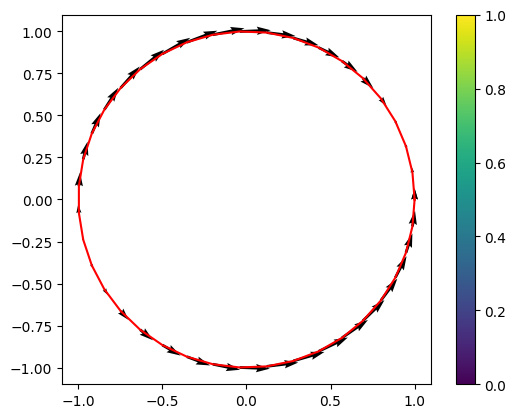

In [ ]:
impermeability_figure = plot_impermeability(z_boundary, v_boundary_pred)
impermeability_figure

In [ ]:
def predicted_stagnation_point_search(shape: PotentialFlowShape, model: torch.nn.Module):

  first_theta_min = 20 * np.pi / 180
  second_theta_min = -160 * np.pi / 180

  def internal_fn(t):
    z, _ = shape.get_boundary(t)
    v_pred, _ = predict(model, z)
    v_mod = np.absolute(v_pred)

    return v_mod

  first_stagnation = fsolve(internal_fn, first_theta_min)
  second_stagnation = fsolve(internal_fn, second_theta_min)
  return np.array((first_stagnation, second_stagnation))


In [ ]:
predicted_stagnation_point_search(cylinder, mlp) * 180 / np.pi

/tmp/ipython-input-3053585782.py:13: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  first_stagnation = fsolve(internal_fn, first_theta_min)
/tmp/ipython-input-3053585782.py:14: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last five Jacobian evaluations.
  second_stagnation = fsolve(internal_fn, second_theta_min)


array([[  19.98062075],
       [-160.06852294]])

<a name="experiments"></a>
## Experiments

<a name="results"></a>
## Results

<a name="conclusions"></a>
## Conclusions

<a name="references"></a>
## References

[1] <a name="Ref1"></a> Fluid Dynamics. Part 1: Classical Fluid Dynamics. Anatoly I. Ruban and Jitesh S. B. Gajjar. ISBN: 9780199681730

[2] <a name="sobol"></a> Halton, John H. “On the efficiency of certain quasi-random sequences of points in evaluating multi-dimensional integrals.” Numerische Mathematik 2.1 (1960): 84-90.

[3] <a name="softadapt"></a> https://docs.nvidia.com/physicsnemo/latest/physicsnemo-sym/user_guide/theory/advanced_schemes.html SoftAdapt section